In [2]:
import jsonlines
import torchaudio
from pathlib import Path
import torch, random
import librosa, os
import IPython.display as ipd
from dotenv import load_dotenv
from spellchecker import SpellChecker
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
from collections import defaultdict
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches
import os

import torch
import torchvision
from torchvision import ops
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

In [4]:
import jsonlines
import pandas as pd

data = {'image': [], 'caption': [], 'bbox': []}
load_dotenv()

TEAM_NAME = os.getenv("TEAM_NAME", "7up")
TEAM_TRACK = os.getenv("TEAM_TRACK", "advanced")


input_dir = Path(f"/home/jupyter/{TEAM_TRACK}")
with jsonlines.open(input_dir / "vlm.jsonl") as reader:
    for obj in reader:
        image = obj['image']
        annotations = obj['annotations']
        for annotation in annotations:
            caption = annotation['caption']
            bbox = annotation['bbox']
            data['image'].append(image)
            data['caption'].append(caption)
            data['bbox'].append(bbox)

df = pd.DataFrame(data)
grouped_df = df.groupby('image').agg(list).reset_index()
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
grouped_df.head()

,image,caption,bbox
0,image_0.jpg,"[grey missile, red, white, and blue light airc...","[[912, 164, 48, 152], [1032, 80, 24, 28], [704..."
1,image_1.jpg,"[grey camouflage fighter jet, grey and white f...","[[1112, 172, 64, 36], [1108, 512, 144, 48], [3..."
2,image_10.jpg,"[blue and grey fighter jet, blue helicopter, b...","[[792, 208, 52, 40], [964, 392, 52, 52], [408,..."
3,image_100.jpg,"[grey camouflage fighter jet, white, black, an...","[[1108, 224, 56, 44], [788, 148, 92, 32], [516..."
4,image_1000.jpg,"[red and white fighter plane, yellow commercia...","[[412, 252, 68, 36], [544, 276, 44, 36], [1092..."


In [5]:
unique_values = ["missile", "light aircraft", "helicopter", "drone", "fighter jet", "commercial aircraft", "cargo aircraft", "fighter plane"]
name2idx = {value: idx for idx, value in enumerate(unique_values)}
idx2name = {v:k for k, v in name2idx.items()}

In [7]:
idx2name

{0: 'missile',
 1: 'light aircraft',
 2: 'helicopter',
 3: 'drone',
 4: 'fighter jet',
 5: 'commercial aircraft',
 6: 'cargo aircraft',
 7: 'fighter plane'}

In [5]:
count = 0
for _, row in grouped_df.iterrows():
    if count == 5:
        break
    x, y, z = row
    print(row)
    count += 1
    

image                                            image_0.jpg
caption    [grey missile, red, white, and blue light airc...
bbox       [[912, 164, 48, 152], [1032, 80, 24, 28], [704...
Name: 0, dtype: object
image                                            image_1.jpg
caption    [grey camouflage fighter jet, grey and white f...
bbox       [[1112, 172, 64, 36], [1108, 512, 144, 48], [3...
Name: 1, dtype: object
image                                           image_10.jpg
caption    [blue and grey fighter jet, blue helicopter, b...
bbox       [[792, 208, 52, 40], [964, 392, 52, 52], [408,...
Name: 2, dtype: object
image                                          image_100.jpg
caption    [grey camouflage fighter jet, white, black, an...
bbox       [[1108, 224, 56, 44], [788, 148, 92, 32], [516...
Name: 3, dtype: object
image                                         image_1000.jpg
caption    [red and white fighter plane, yellow commercia...
bbox       [[412, 252, 68, 36], [544, 276, 44, 36], [1

In [8]:
import os

def convert_bbox_to_yolo(img_width, img_height, tlwh_bbox):
    x_tl, y_tl, w, h = tlwh_bbox
    cx = x_tl + w / 2.0
    cy = y_tl + h / 2.0
    return [cx / img_width, cy / img_height, w / img_width, h / img_height]

def get_class_id_from_caption(caption, name2idx):
    for name, idx in name2idx.items():
        if name in caption:
            return idx
    return None

base_path = "dataset_vlm2"

label_train_path = os.path.join(base_path, "labels")
os.makedirs(label_train_path, exist_ok=True)
img_width = 1520
img_height = 870

for _, row in grouped_df.iterrows():
    filename = row['image']
    bboxes = row['bbox']
    captions = row['caption']

    label_path = os.path.join(label_train_path, filename.replace(".jpg", ".txt"))

    with open(label_path, 'w') as f:
        for bbox, caption in zip(bboxes, captions):
            yolo_bbox = convert_bbox_to_yolo(img_width, img_height, bbox)
            
            class_id = get_class_id_from_caption(caption, name2idx)
            if class_id is not None:
                # Write bbox to label file
                f.write(f"{class_id} {yolo_bbox[0]:.6f} {yolo_bbox[1]:.6f} {yolo_bbox[2]:.6f} {yolo_bbox[3]:.6f}\n")

print("Dataset preparation complete.")

Dataset preparation complete.


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


WARNING ⚠️ NMS time limit 0.550s exceeded
0: 384x640 1 grey missile, 1 blue and white missile, 1 blue, yellow, and black helicopter, 257.1ms
Speed: 222.4ms preprocess, 257.1ms inference, 1468.5ms postprocess per image at shape (1, 3, 384, 640)


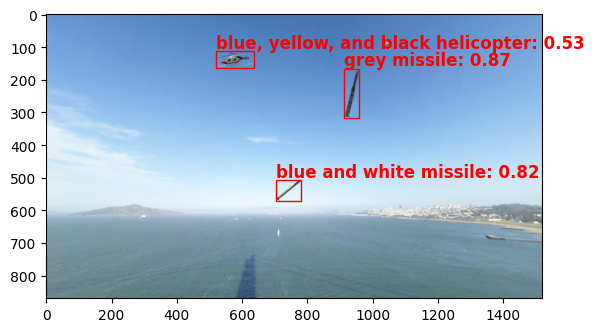

In [1]:
from typing import List
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
import io
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt

class VLMManager:
    def __init__(self):
        self.model_id = "IDEA-Research/grounding-dino-base"
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.processor = AutoProcessor.from_pretrained(self.model_id)
        self.model = AutoModelForZeroShotObjectDetection.from_pretrained(self.model_id)
        self.model.to(self.device)
        self.yolo_model = YOLO("/home/jupyter/til-24-base/vlm/src/yv3_150/weights/best.pt")
        self.yolo_model.to(self.device)
        self.list = [
            'grey missile', 'red, white, and blue light aircraft', 'green and black missile', 'white and red helicopter',
            'grey camouflage fighter jet', 'grey and white fighter plane', 'white and black drone', 'white and black fighter jet',
            'white missile', 'black and white commercial aircraft', 'grey drone', 'yellow, red, and grey helicopter',
            'yellow commercial aircraft', 'black cargo aircraft', 'yellow helicopter', 'white and black light aircraft',
            'grey and black fighter plane', 'red fighter plane', 'blue helicopter', 'white, red, and green fighter plane',
            'black camouflage fighter jet', 'green light aircraft', 'blue and yellow fighter jet', 'white fighter jet',
            'red fighter jet', 'blue and white light aircraft', 'white and black helicopter', 'white and blue fighter plane',
            'grey commercial aircraft', 'blue and grey fighter jet', 'green and brown camouflage fighter jet', 'red and grey missile',
            'red and white fighter jet', 'orange light aircraft', 'yellow light aircraft', 'white and red light aircraft',
            'white and grey helicopter', 'blue, yellow, and green fighter plane', 'yellow and red light aircraft', 'blue and white missile',
            'green and white fighter plane', 'blue missile', 'grey, red, and blue commercial aircraft', 'white light aircraft',
            'grey and white light aircraft', 'blue and yellow helicopter', 'white fighter plane', 'white and blue fighter jet',
            'blue camouflage fighter jet', 'yellow and green helicopter', 'silver fighter plane', 'blue and red light aircraft',
            'white and black cargo aircraft', 'green and yellow fighter plane', 'white and blue cargo aircraft',
            'blue and red commercial aircraft', 'blue, yellow, and white cargo aircraft', 'white and yellow commercial aircraft',
            'white and red missile', 'white cargo aircraft', 'grey helicopter', 'grey and red commercial aircraft', 'white drone',
            'yellow, black, and red helicopter', 'white and blue helicopter', 'green and grey helicopter', 'black and brown camouflage helicopter',
            'blue and green fighter plane', 'green missile', 'grey cargo aircraft', 'yellow fighter jet', 'yellow, red, and blue fighter plane',
            'grey and red missile', 'orange and black fighter jet', 'white and blue light aircraft', 'white and black fighter plane',
            'grey and green cargo aircraft', 'blue commercial aircraft', 'grey fighter jet', 'black fighter plane',
            'white, black, and red drone', 'blue and white commercial aircraft', 'red, white, and blue fighter jet',
            'white, black, and grey missile', 'black fighter jet', 'red and white missile', 'white and orange light aircraft',
            'white and red commercial aircraft', 'yellow fighter plane', 'silver and blue fighter plane', 'grey and red fighter jet',
            'red helicopter', 'black and white missile', 'grey and black helicopter', 'red and white light aircraft',
            'green and black camouflage helicopter', 'black and orange drone', 'grey and yellow fighter plane',
            'green camouflage helicopter', 'black drone', 'white and blue commercial aircraft', 'blue and white helicopter',
            'green fighter plane', 'red and black drone', 'white and orange commercial aircraft', 'green helicopter', 'black helicopter',
            'white, red, and blue commercial aircraft', 'black and yellow missile', 'yellow and black fighter plane',
            'white, blue, and red commercial aircraft', 'grey fighter plane', 'red light aircraft', 'green and brown camouflage fighter plane',
            'blue, yellow, and black helicopter', 'grey light aircraft', 'white commercial aircraft', 'green and brown camouflage helicopter',
            'white and red fighter plane', 'red and white fighter plane', 'red and white helicopter', 'black and white cargo aircraft',
            'white helicopter', 'black and yellow drone', 'yellow missile', 'white and red fighter jet'
        ]

    def identify(self, image: bytes, caption: str) -> List[tuple]:
        # perform object detection with a vision-language model
        if caption in self.list:
            image = self.process_image(image)
            results = self.run_yolo_model(image, caption, 0.30)
            if not results:
                text = "a " + caption.lower() + "."
                result = self.run_model(image, text)
                scores_list = result[0]['scores'].tolist()
                # Get the index of the maximum score
                max_score_index = scores_list.index(max(scores_list))
                # Retrieve the box with the highest score
                box_with_highest_score = result[0]['boxes'][max_score_index].tolist()
                bbox = self.convert_bbox_format(box_with_highest_score)
                return [(bbox, scores_list[max_score_index], caption)]
            else:
                return results
        else:
            text = "a " + caption.lower() + "."
            image = self.process_image(image)
            result = self.run_model(image, text)
            scores_list = result[0]['scores'].tolist()
            # Get the index of the maximum score
            max_score_index = scores_list.index(max(scores_list))
            # Retrieve the box with the highest score
            box_with_highest_score = result[0]['boxes'][max_score_index].tolist()
            bbox = self.convert_bbox_format(box_with_highest_score)
            return [(bbox, scores_list[max_score_index], caption)]

    def process_image(self, image_data: bytes) -> Image:
        image = Image.open(io.BytesIO(image_data)).convert("RGB")
        return image

    def run_model(self, image: Image, text: str):
        inputs = self.processor(images=image, text=text, return_tensors="pt").to(self.device)
        
        with torch.no_grad():
            outputs = self.model(**inputs)

        results = self.processor.post_process_grounded_object_detection(
            outputs,
            inputs.input_ids,
            box_threshold=0.2,
            text_threshold=0.3,
            target_sizes=[image.size[::-1]]
        )
        
        return results
    
    def convert_bbox_format(self, bbox: List[float]) -> List[int]:
        xmin, ymin, xmax, ymax = bbox
        width = xmax - xmin
        height = ymax - ymin
        return [int(xmin), int(ymin), int(width), int(height)]

    def run_yolo_model(self, image: Image, text: str, threshold: float) -> List[tuple]:
        image_np = np.array(image)
        results_list = self.yolo_model(image_np)
        detections = []

        for results in results_list:
            if hasattr(results, 'boxes'):
                for box in results.boxes:
                    cls = box.cls[0].item()
                    x1, y1, x2, y2 = box.xyxy[0].tolist()
                    conf = box.conf[0].item()
                    # if conf >= threshold:
                    detections.append(([int(x1), int(y1), int(x2 - x1), int(y2 - y1)], conf, results.names[int(cls)]))

        return detections

    def plot_bounding_boxes(self, image: Image, bboxes: List[tuple]):
        plt.imshow(image)
        ax = plt.gca()
        for bbox, score, label in bboxes:
            rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            plt.text(bbox[0], bbox[1] - 10, f'{label}: {score:.2f}', color='red', fontsize=12, weight='bold')
        plt.show()


# Test the VLMManager class on a single photo and plot the bounding box
if __name__ == "__main__":
    import requests

    vlm_manager = VLMManager()

    with open("images_image_0.jpg", "rb") as f:
        image_data = f.read()

    # Specify the caption
    caption = "red, white, and blue light aircraft"

    # Identify the object and get the bounding box
    bbox = vlm_manager.identify(image_data, caption)

    # Plot the bounding box on the image
    image = vlm_manager.process_image(image_data)
    vlm_manager.plot_bounding_boxes(image, bbox)


In [16]:
caption = "green and black missile"
caption.split()[-1]

'missile'

In [2]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from torchvision.models import yolov3

model = yolov3(pretrained=True)
model

ImportError: cannot import name 'yolov3' from 'torchvision.models' (/opt/conda/lib/python3.10/site-packages/torchvision/models/__init__.py)